In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('Immo_data.csv', encoding="utf-8")
df.head

<bound method NDFrame.head of        Unnamed: 0        Id        Locality       Type    SubType   Price  \
0               0  20316087        Ertvelde      House      house  329000   
1               1  20316069           Hornu      House      house  180000   
2               2  20316048         Beersel      House      house  369000   
3               3  20316039  Geraardsbergen      House      house  145000   
4               4  20316038  Geraardsbergen      House      house  269000   
...           ...       ...             ...        ...        ...     ...   
10679       12178   8972064    Blankenberge  Apartment  apartment  324146   
10680       12181   8945382          Knokke  Apartment     duplex  699000   
10681       12185   8746466          Knokke  Apartment  apartment  950000   
10682       12189   8498727    Ingelmunster  Apartment  apartment  562500   
10683       12200   7961536         Aarsele  Apartment  apartment  305000   

       Bedrooms  Living_Area  Is_Equiped_Kitc

## Check for duplicates

In [43]:
print(df.duplicated().sum())

0


## Check for NaN values

In [44]:
# None found - Already dealt with during previous project phase
missing_values = df.isna().sum()
print(missing_values)

Unnamed: 0            0
Id                    0
Locality              0
Type                  0
SubType               0
Price                 0
Bedrooms              0
Living_Area           0
Is_Equiped_Kitchen    0
Is_Furnished          0
Is_Open_Fire          0
Terrace               0
Terrace_Area          0
Garden                0
Garden_Area           0
Land_Surface          0
State                 0
Facades               0
Swim_pool             0
Municipality          0
Region                0
Surface_total         0
dtype: int64


I want to make sure that Garden_Area and Terrace_Area always has values greater than 0 if Garden and Terrace is 1 (True)


In [45]:
# Decide which columns to keep

garden_inconsistent = df[(df['Garden'] == 1) & (df['Garden_Area'] == 0)]
terrace_inconsistent = df[(df['Terrace'] == 1) & (df['Terrace_Area'] == 0)]

garden_inconsistent_count = len(garden_inconsistent)
terrace_inconsistent_count = len(terrace_inconsistent)

print(f"Garden has {garden_inconsistent_count} inconsistent values")
print(f"Terrace has {terrace_inconsistent_count} inconsistent values")

Garden has 0 inconsistent values
Terrace has 2231 inconsistent values


Terrace has a significant amount of inconsistent values but I'm not ready to drop it yet.
I'm going to impute Terrace_Area and decide later if it's significant or not

In [46]:
terrace_area_mean = df.loc[(df['Terrace'] == 1) & (df['Terrace_Area'] > 0), 'Terrace_Area'].mean()
df.loc[(df['Terrace'] == 1) & (df['Terrace_Area'] <= 0), 'Terrace_Area'] = terrace_area_mean

terrace_inconsistent_after = len(df[(df['Terrace'] == 1) & (df['Terrace_Area'] <= 0)])
print(f"Terrace has {terrace_inconsistent_after} inconsistent values")

Terrace has 0 inconsistent values


C:\Users\T570\AppData\Local\Temp\ipykernel_7220\1715122426.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '21.296673189823874' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Terrace'] == 1) & (df['Terrace_Area'] <= 0), 'Terrace_Area'] = terrace_area_mean


Region, Locality and Municipality are similiar so I'm only going to keep one.

I'm going to keep Region because it only has 3 categories and already encapsulates geographic variability + will be easier to interpret.

Dropping Municipality and Locality because there are a lot of unique values and I want to avoid overfitting.
I dont think they will contribute much more predictive power.

**Edit**: Adding Municipality back in to see if that will up my score. Region is currently strongest feature but all strategies thus far are only having minimal improvement. Perhaps more granular location data might help. Municipality with 11 unique values vs locality with 806 unique values could be the happy medium.

In [47]:
locality_counts = df['Locality'].nunique()
municipality_counts = df['Municipality'].nunique()

print(f"Locality: {locality_counts}")
print(f"Municipality: {municipality_counts}")

Locality: 806
Municipality: 11


Municipality had a 1% improvment wich is still minimal but more effective than most trategies thus far.

Going to try adding average income next.

In [49]:
income_df_unique = income_df.groupby("TX_MUNTY_DESCR_NL")[["MS_TOT_NET_TAXABLE_INC", "MS_NBR_TOT_NET_INC"]].mean().reset_index()

income_df_unique["Average_Income"] = income_df_unique["MS_TOT_NET_TAXABLE_INC"] / income_df_unique["MS_NBR_TOT_NET_INC"]

df = df.merge(income_df_unique[["TX_MUNTY_DESCR_NL", "Average_Income"]],
              left_on="Locality",
              right_on="TX_MUNTY_DESCR_NL",
              how="left")


print(f"Number of records after merge: {len(df)}")


Number of records after merge: 10684


In [50]:
df = df.drop(columns=['Locality'])


In [51]:
num_missing = df['Average_Income'].isna().sum()
print(f"Number of missing values in Average_Income: {num_missing}")

# Impute based on municipality
df['Average_Income'] = df.groupby('Municipality')['Average_Income'].transform(
    lambda x: x.fillna(x.mean())
)


Number of missing values in Average_Income: 5778


In [52]:
num_missing = df['Average_Income'].isna().sum()
print(f"Number of missing values in Average_Income: {num_missing}")

Number of missing values in Average_Income: 0


Also going to drop the unnamed column and the Id col because these are not relvenat to predictive models.

In [53]:
df = df.drop(columns=['Unnamed: 0', 'Id'])

Based on previous analysis is_furnished has the least correlation with price due to only haveing around 3% 'True' values. So dropping it as well.

In [54]:
df = df.drop(columns=['Is_Furnished'])

I am going to remove Land_Surface and Surface_total because something doesn't look right to me and I don't trust these columns.
Land_Surface often has the same values as Living_Area - not always but enough to make me suspicious. Surface total sums up Land_Surface and Living_Area, so if my suspicions are correct then this will have a lot of incorrect data. It also has lots a 0 values despite the other 2 having values. Therfore they are UNINVITED.

I think Living_Area has the most accurate size data per property and should suffice for predicting price based off property size (along with Garden_Area).

In [55]:
df = df.drop(columns=['Land_Surface', 'Surface_total'])

I want to remove 'mixed-use-building' from SubType because it includes commercial buildings and I want to focus only on residential - plus it is less than 2% of my dataset.

In [56]:
mixed_use_count = df[df['SubType'] == 'mixed-use-building'].shape[0]
total_rows = df.shape[0]
mixed_use_percentage = (mixed_use_count / total_rows) * 100

print(f"Percentage of rows with 'mixed-use-building': {mixed_use_percentage:.2f}%")


Percentage of rows with 'mixed-use-building': 1.86%


In [57]:
df = df[df['SubType'] != 'mixed-use-building']

## Encode Text data

In [58]:
df.dtypes

Type                   object
SubType                object
Price                   int64
Bedrooms                int64
Living_Area             int64
Is_Equiped_Kitchen      int64
Is_Open_Fire            int64
Terrace                 int64
Terrace_Area          float64
Garden                  int64
Garden_Area             int64
State                   int64
Facades                 int64
Swim_pool               int64
Municipality           object
Region                 object
TX_MUNTY_DESCR_NL      object
Average_Income        float64
dtype: object

In [59]:
df.columns

Index(['Type', 'SubType', 'Price', 'Bedrooms', 'Living_Area',
       'Is_Equiped_Kitchen', 'Is_Open_Fire', 'Terrace', 'Terrace_Area',
       'Garden', 'Garden_Area', 'State', 'Facades', 'Swim_pool',
       'Municipality', 'Region', 'TX_MUNTY_DESCR_NL', 'Average_Income'],
      dtype='object')

In [60]:
label_encoder = LabelEncoder()

label_mapping = {} # To keep track of which labels go with which value

# Encode only strings
for col in df.select_dtypes(include='object').columns:
    df[col] = label_encoder.fit_transform(df[col])
    label_mapping[col] = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Manually adding labels for State because this was encoded previously
label_mapping['State'] = {
    1: 'Good',
    2: 'Not Known',
    3: 'As new',
    4: 'To renovate',
    5: 'To be done up',
    6: 'Just renovated',
    7: 'To restore'
}

# Add to dictionary
for col, mapping in label_mapping.items():
    print(f"Mapping for {col}: {mapping}")
    
# Save to json file
with open('label_mappings.json', 'w') as f:
    json.dump(label_mapping, f)

Mapping for Type: {'Apartment': 0, 'House': 1}
Mapping for SubType: {'apartment': 0, 'apartment-block': 1, 'duplex': 2, 'exceptional-property': 3, 'flat-studio': 4, 'ground-floor': 5, 'house': 6, 'mansion': 7, 'penthouse': 8, 'town-house': 9, 'villa': 10}
Mapping for Municipality: {'Antwerpen': 0, 'Brussel': 1, 'Henegouwen': 2, 'Limburg': 3, 'Luik': 4, 'Luxemburg': 5, 'Namen': 6, 'Oost-Vlaanderen': 7, 'Vlaams-Brabant': 8, 'Waals-Brabant': 9, 'West-Vlaanderen': 10}
Mapping for Region: {'Brussel': 0, 'Flanders': 1, 'Wallonia': 2}
Mapping for TX_MUNTY_DESCR_NL: {'Aalst': 0, 'Aalter': 1, 'Aarschot': 2, 'Aartselaar': 3, 'Affligem': 4, 'Alken': 5, 'Alveringem': 6, 'Amay': 7, 'Andenne': 8, 'Anderlecht': 9, 'Anderlues': 10, 'Anhée': 11, 'Ans': 12, 'Anthisnes': 13, 'Antoing': 14, 'Antwerpen': 15, 'Anzegem': 16, 'Ardooie': 17, 'Arendonk': 18, 'Asse': 19, 'Assenede': 20, 'Attert': 21, 'Aubange': 22, 'Aubel': 23, 'Avelgem': 24, 'Awans': 25, 'Aywaille': 26, 'Balen': 27, 'Beernem': 28, 'Beerse': 29,

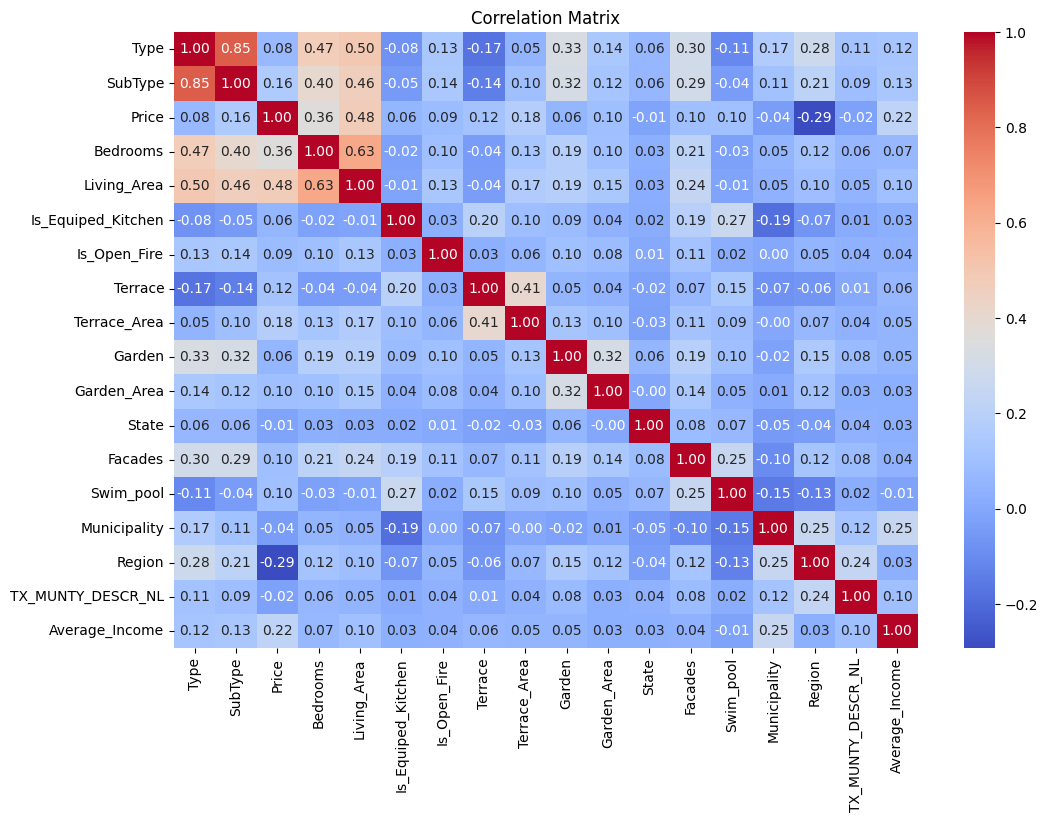

In [61]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


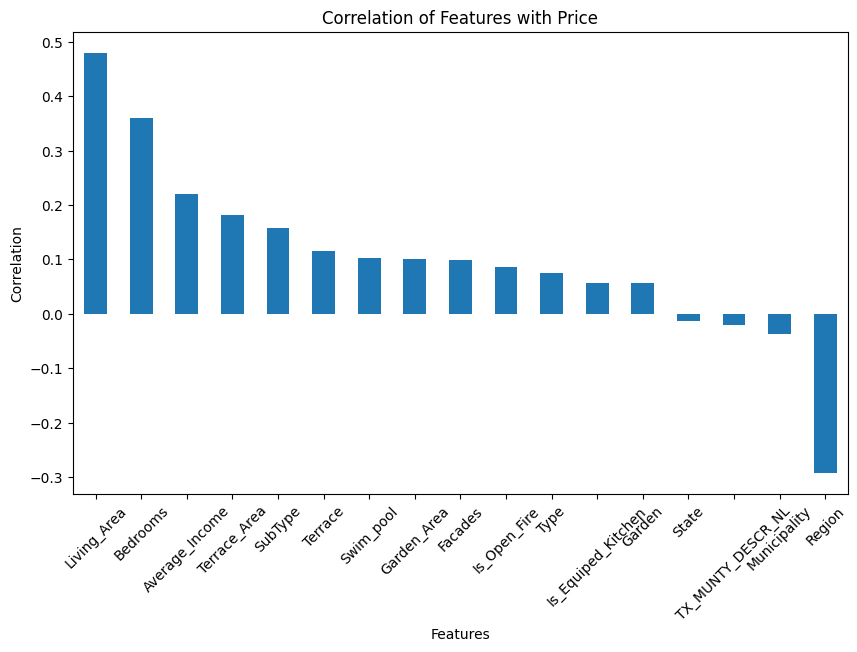

In [62]:
price_correlation = correlation_matrix['Price'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
price_correlation.drop('Price').plot(kind='bar')
plt.title("Correlation of Features with Price")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.show()

Type and SubType has a high correlation of 0.85 so I should remove one.
I'm going to check for sparsity in SubType and decide which one to keep based on that.

C:\Users\T570\AppData\Local\Temp\ipykernel_7220\1077500967.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sub_type_counts.index, y=sub_type_counts.values, palette="viridis")


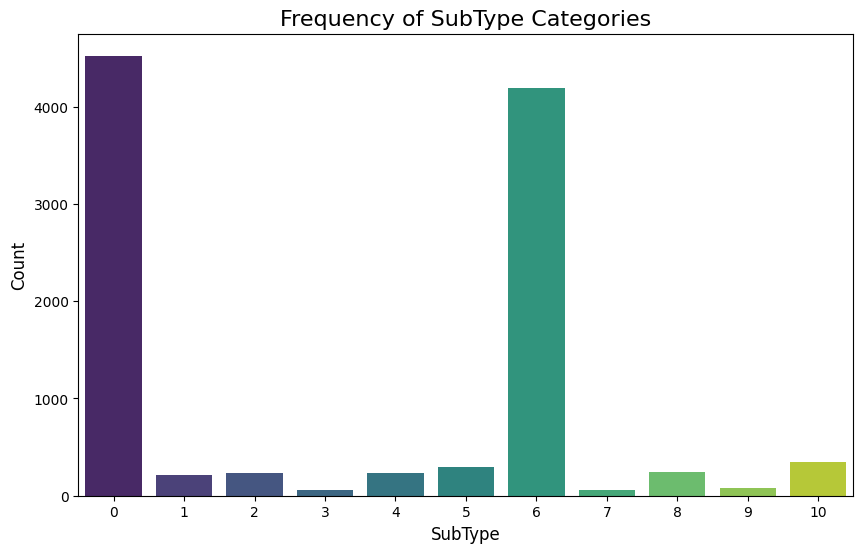

In [63]:
sub_type_counts = df['SubType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=sub_type_counts.index, y=sub_type_counts.values, palette="viridis")

plt.title('Frequency of SubType Categories', fontsize=16)
plt.xlabel('SubType', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


Two dominant categories (house and apartment) while the rest has very small frequency. Not worth keeping.

In [64]:
df = df.drop(columns=['SubType'])

C:\Users\T570\AppData\Local\Temp\ipykernel_7220\1461506236.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pool_counts.index, y=pool_counts.values, palette="viridis")


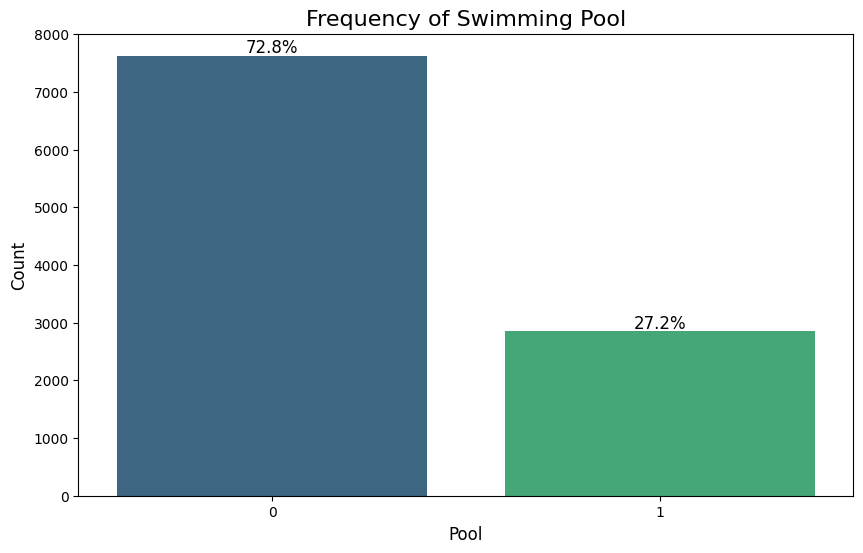

In [65]:
pool_counts = df['Swim_pool'].value_counts()

pool_counts = df['Swim_pool'].value_counts()
pool_percentages = (pool_counts / len(df)) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=pool_counts.index, y=pool_counts.values, palette="viridis")

for index, value in enumerate(pool_counts.values):
    percentage = pool_percentages.iloc[index]
    plt.text(index, value + 50, f'{percentage:.1f}%', ha='center', fontsize=12)

plt.title('Frequency of Swimming Pool', fontsize=16)
plt.xlabel('Pool', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


Over 25% of my dataset has a pool so it can still contribute insight. Will Keep.

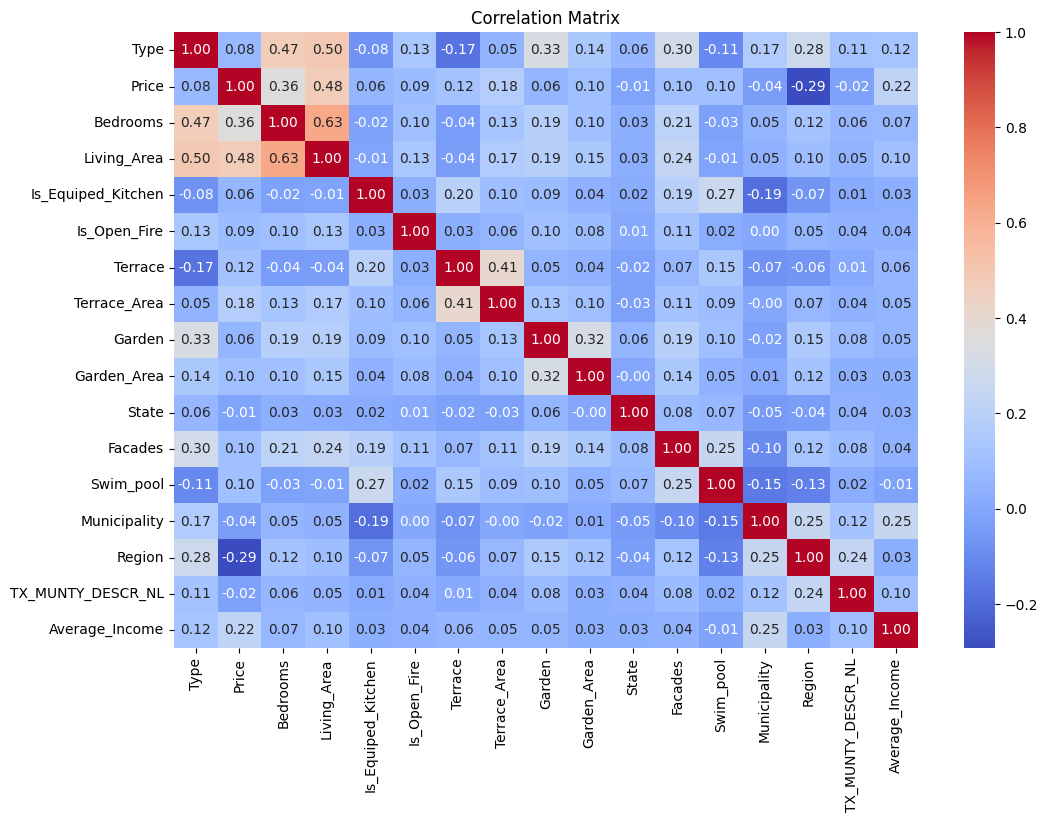

In [66]:
# Updated correlation heatmap
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


## Features to consider removing

I'm going to test with the model first and then decide which to remove based on feature importance scores.

- **Region** - Strong negative correlation, but I still think location should have a big impact on price.
- **State** - Very weak correlation
- **Is_Equipped_Kitchen**, **Is_Open_Fire** - Weak correlations with Price and I don't think these will provide any meaningful insight.
- **Swim_pool**: Low correlation but I feel like a pool does have an effect on price.
- **Terrace** and **Garden**: Might be redundant because we have Area? 
- **Facade**: Low correlation but could indicate neighbour proximity effect on price.

# Strategies after Baseline Model

These are the strategies that had a positive impact on the score (albeit minimal).

In [67]:
# Bin Bedrooms
bins = [-1, 1, 3, 5, 10, float('inf')]  
labels = ['Studio/Small', 'Small Family', 'Medium Family', 'Large', 'Luxury']

df['Bedroom_Bin'] = pd.cut(df['Bedrooms'], bins=bins, labels=labels)

print(df[['Bedrooms', 'Bedroom_Bin']].head())

   Bedrooms   Bedroom_Bin
0         2  Small Family
1         3  Small Family
2         6         Large
3         2  Small Family
4         3  Small Family


In [68]:
# Encode Bedroom bins
bedroom_bin_mapping = {
    'Studio/Small': 1, 
    'Small Family': 2, 
    'Medium Family': 3, 
    'Large': 4, 
    'Luxury': 5
}
df['Bedroom_Bin_Code'] = df['Bedroom_Bin'].map(bedroom_bin_mapping)
df = df.drop(columns=['Bedroom_Bin'])

In [69]:
# Columns with less than 0.3% feature importance
df = df.drop(columns=['Garden', 'Terrace', 'Is_Open_Fire'])

In [70]:
# Aggregation of outdoor areas
df['Total_Outdoor_Area'] = df['Terrace_Area'] + df['Garden_Area']
df = df.drop(columns=['Terrace_Area', 'Garden_Area'])

In [71]:
# Log Transform Living_Area
df['Log_Living_Area'] = np.log1p(df['Living_Area'])
df = df.drop(columns=['Living_Area'])

In [72]:
#Sqrt transform Total_Outdoor_Area
df['Sqrt_Total_Outdoor_Area'] = np.sqrt(df['Total_Outdoor_Area'])
df = df.drop(columns=['Total_Outdoor_Area'])

In [74]:
df.describe

<bound method NDFrame.describe of        Type   Price  Bedrooms  Is_Equiped_Kitchen  State  Facades  Swim_pool  \
0         1  329000         2                   1      1        3          0   
1         1  180000         3                   0      3        2          1   
2         1  369000         6                   0      5        3          1   
3         1  145000         2                   1      1        2          0   
4         1  269000         3                   1      1        2          0   
...     ...     ...       ...                 ...    ...      ...        ...   
10679     0  324146         2                   0      1        0          0   
10680     0  699000         4                   0      3        0          0   
10681     0  950000         2                   0      3        2          0   
10682     0  562500         3                   0      1        0          0   
10683     0  305000         2                   1      1        0          0   

     

# Save Processed Dataset!

In [73]:
df.to_csv('immo-ml-data.csv', index=False)